# Re-Coloring Greyscale Images with CIFAR-10

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_cifar10
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Load In Data

In [68]:
batches = load_cifar10.Batches()
train_batches = batches[:5]
test_batch = batches[5]

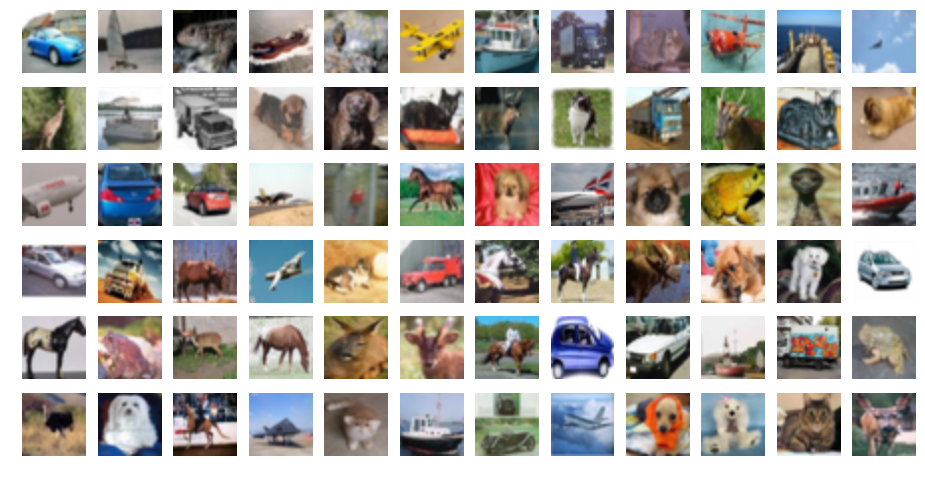

In [69]:
figsize(16, 8)
_, ax = plt.subplots(6, 12)
for a in ax.reshape(np.prod(ax.shape)):
    a.imshow(test_batch[np.random.randint(0, 10000)])
    a.axis("off")
plt.show()

## Some Utility Functions

In [ ]:
def Greyscale(images):
    return 